In [2]:
import pandas as pd
import csv
import os
import numpy
import copy
%matplotlib inline

In [3]:
import numpy as np
import seaborn as sns

In [4]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models, similarities, matutils
from gensim.corpora.dictionary import Dictionary
from sklearn.cluster import DBSCAN

Load ISIS data set and clean tweets

In [5]:
df = pd.read_csv('/media/patrick/MY_EXTERNAL/ISIS/tweets.csv', parse_dates= [6])

In [6]:
def clean_tweet(tweet):
    ext = "http"
    text = tweet[:tweet.find(ext)].lower()
    text = re.sub("[^\S]", " ", text)
    text = re.sub("english translation ", "", text)
    textOnly = re.sub("[^a-zA-Z0-9@# ]", "", text)
    return(textOnly)

In [7]:
df.tweets = df.tweets.apply(clean_tweet)

### Vectorize using each tweet as a document

In [8]:
# create a list of all cleaned tweets to create word vectors
tweetList = list(df.tweets)

In [9]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                  ngram_range=(1,1), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
tfidf_vectorizer.fit(tweetList)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='\\b[a-z][a-z]+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [10]:
ng_vecs = tfidf_vectorizer.transform(tweetList).transpose()
print(ng_vecs.shape)
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(ng_vecs)

(22751, 17410)


In [11]:
dictionary = Dictionary.from_corpus(corpus,
                                    id2word=dict((id, word) for word, id in tfidf_vectorizer.vocabulary_.items()))

In [12]:
# Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
# num_topics is the number of dimensions to reduce to after the SVD
# Analagous to "fit" in sklearn, it primes an LSI space
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=300)

In [13]:
lsi_corpus = lsi[corpus]

In [14]:
# Dump the resulting documentwe vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]

In [15]:
# Create an index transformer that calculates similarity based on our space
index = similarities.MatrixSimilarity(doc_vecs)

In [16]:
type(index)

gensim.similarities.docsim.MatrixSimilarity

In [17]:
# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[1]]), key=lambda item: -item[1])
sims[:20]

[(1, 1.0),
 (2, 0.88126397),
 (28, 0.79845572),
 (0, 0.75816226),
 (3, 0.7528795),
 (12, 0.7148782),
 (4, 0.68594134),
 (8357, 0.67314088),
 (11091, 0.65163422),
 (15441, 0.61060572),
 (1089, 0.57558072),
 (6754, 0.57290483),
 (6, 0.56630075),
 (983, 0.55303663),
 (2702, 0.55235636),
 (4411, 0.54809177),
 (12978, 0.54099357),
 (7627, 0.54022473),
 (3120, 0.53641415),
 (3141, 0.53641415)]

In [18]:
tweetList[1]

'english translation sheikh fatih al jawlani for the people of integrity sacrifice is  easy '

In [19]:
tweetList[28]

'english translation dialogue with sheikh tartoosi part 2   '

In [20]:
dbscan = DBSCAN(random_state=111)
dbscan

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    min_samples=5, p=None, random_state=111)

In [21]:
dbscan.fit(index)

/home/patrick/anaconda3/lib/python3.5/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


MemoryError: 

In [ ]:
dbscan.labels_

In [ ]:
for tweet in tweetList:
    if 'anominon' in tweet:
        print(tweet)

In [ ]:
for username in df.username.unique():
    df = df[df.username == username]
    
    break

In [146]:
df['hour'] = [item.hour for item in df.time]

df_time = df[['tweets', 'time']]

df_time.groupby('time').count().plot(kind ='bar', figsize=(15,8), legend =False)

In [24]:
df_time.tweets.value_counts()

19    1397
18    1385
20    1366
21    1198
17    1110
15    1088
14    1060
16    1009
22     978
13     917
12     755
10     640
23     637
11     634
9      568
6      390
8      390
0      387
7      348
1      293
5      259
2      221
4      216
3      164
Name: hour, dtype: int64

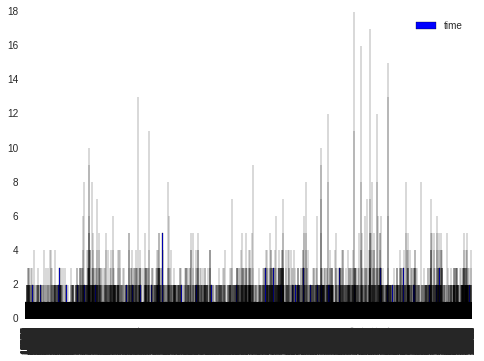

In [39]:
pd.DataFrame(df_time.time.value_counts()).reset_index().sort_values('index').plot(kind='bar')

In [263]:
tsh = df.set_index(pd.DatetimeIndex(df['time']))

In [281]:
perhr = tsh.resample('D', how='count')

In [282]:
tsh

,name,username,description,location,followers,numberstatuses,time,tweets
2015-01-06 21:07:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:07:00,english translation a message to the truthful ...
2015-01-06 21:27:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:27:00,english translation sheikh fatih al jawlani fo...
2015-01-06 21:29:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:29:00,english translation first audio meeting with s...
2015-01-06 21:37:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:37:00,english translation sheikh nasir al wuhayshi h...
2015-01-06 21:45:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:45:00,english translation aqap response to sheikh ba...
2015-01-06 21:51:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:51:00,the second clip in a dawah series by a soldier...
2015-01-06 22:04:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 22:04:00,english transcript oh murabit
2015-01-06 22:06:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 22:06:00,english translation a collection of the words ...
2015-01-06 22:17:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 22:17:00,aslm please share our new account after the pr...
2015-01-10 00:05:00,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-10 00:05:00,english translation aqap statement regarding t...


In [274]:
import matplotlib.pyplot as plt

In [283]:
perhr

,name,username,description,location,followers,numberstatuses,time,tweets
2015-01-06,9,9,9,0,9,9,9,9
2015-01-07,0,0,0,0,0,0,0,0
2015-01-08,0,0,0,0,0,0,0,0
2015-01-09,0,0,0,0,0,0,0,0
2015-01-10,2,2,2,0,2,2,2,2
2015-01-11,0,0,0,0,0,0,0,0
2015-01-12,1,1,1,0,1,1,1,1
2015-01-13,0,0,0,0,0,0,0,0
2015-01-14,0,0,0,0,0,0,0,0
2015-01-15,0,0,0,0,0,0,0,0


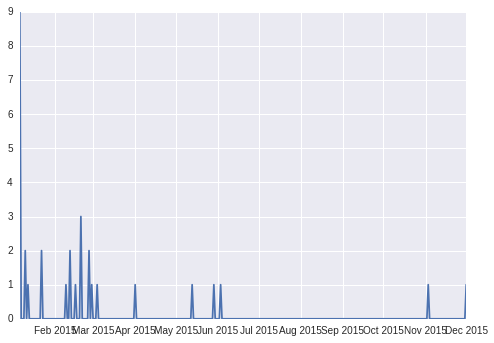

In [284]:
plt.plot(perhr.index.values,perhr.tweets,label = 'Hillary')